# CMSC320 - Introduction to Data Science
## Final Tutorial
#### David Martin
---

**Introduction**

Welcome to my CMSC320 Data Science Final Tutorial!

In this tutorial, we will be showing how we can use Python data scraping, modeling, and regression testing libraries to perform some basic analysis on COVID data in the state of Virginia. The goal is to visualize, model, and gain some insight on the impact of COVID across the state. 

We will start by scraping our COVID reporting data off of the [Virginia Open Data Portal](https://data.virginia.gov/). Then, we will process and tidy our data for our exploratory data analysis. After performing our analysis, we will use [regression testing](https://en.wikipedia.org/wiki/Regression_testing) to see if a significant correlation between county population size and COVID transmission/death rates exists. Finally, we will wrap it all up by concluding any of our findings.

Let's get started!

**Imports**

The following is an import list of all the Python modules we will use for the following tutorial, as well as some global styling settings.

In [368]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import requests
import warnings
from sklearn.linear_model import LinearRegression
from fuzzywuzzy import process
from bs4 import BeautifulSoup
from datetime import date
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

---
## Data Collection

The purpose of this section is to begin our analysis by collecting our data. I went to [Virginia's](https://data.virginia.gov) public data page and found a great dataset on COVID reporting organized by county. Each row is an individual county's report on their current running total of cases, hospitalizations, and deaths. Each day has a report from each county. Let's use this as our main data set for this analysis.

Let's start by pulling the data from the dataset [VDH-COVID-19-PublicUseDataset-Cases](https://data.virginia.gov/Government/VDH-COVID-19-PublicUseDataset-Cases/bre9-aqqr) and taking a look at what it contains:

I cloned the dataset and put it in a [GitHub Repository](https://github.com/martindavid1995/Data-Science-Tutorial) in .csv format so that we can have a copy of the data without worrying about it changing on us in the future. We will use [Pandas](https://pandas.pydata.org/pandas-docs/stable/) to read from that .csv and put it into a DataFrame so that we can begin working with it.

In [369]:
# Pull data on COVID cases across Virginia
covid_data = pd.read_csv("https://raw.githubusercontent.com/martindavid1995/Data-Science-Tutorial/master/Covid_VA.csv")
# Display the first five entries
covid_data.head()

,Report Date,FIPS,Locality,VDH Health District,Total Cases,Hospitalizations,Deaths
0,03/17/2020,51001,Accomack,Eastern Shore,0,0,0
1,03/17/2020,51003,Albemarle,Thomas Jefferson,0,0,0
2,03/17/2020,51005,Alleghany,Alleghany,0,0,0
3,03/17/2020,51007,Amelia,Piedmont,0,0,0
4,03/17/2020,51009,Amherst,Central Virginia,0,0,0


In looking at this DataFrame, we see our listed columns. Each row in our table contains a particular county's case, hospitalization, and death **cumulative** counts for a particular day. Before ending this section, we might want to consider any more information that might be useful for us to get a good understanding of what COVID looks like in Virginia.

Since each row in our dataset represents a different county, it might be helpful for us to get an idea of what counties have the largest and smallest populations. For example, looking at death rate: three deaths in a single day in a Virginia county with a population of over 1 million people means significantly less than three deaths in a county with a population of 4,000 people in terms of virus deadliness. This is something we might want to consider when exploring our data, so we should attempt to find some population metrics for each county.

A google search of [Virginia Counties by Population](https://www.virginia-demographics.com/counties_by_population) brings us to a website with a chart containing a value for each of Virginia's 133 counties. While we could sit here and manually enter the populations by hand, we can use python and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip the population data off this webpage so that we don't have to do all that manual data entry.

In [370]:
# Use requests to pull data from URL
r = requests.get("https://www.virginia-demographics.com/counties_by_population")
# Use BeautifulSoup to parse the request's HTML
soup = BeautifulSoup(r.content, 'html.parser')
# Find the table object and prettify it
table = soup.find('table').prettify()
# Convert the table into a DataFrame
populations = pd.read_html(str(table))[0]
# Drop the last row because it has data we don't need
populations = populations.drop(index=len(populations.index)-1)
# Display the first five entries
populations.head()

,Rank,County,Population
0,1,Fairfax County,1149439
1,2,Prince William County,466834
2,3,Virginia Beach city/county,450882
3,4,Loudoun County,405312
4,5,Chesterfield County,348500


Perfect! Now we have all of the data we are going to need for this analysis. We have our COVID reporting data and population sizes for each of the 133 Virginian counties. In the next section, we will begin manipulating these DataFrames so that we are able to have all the information in the format that we need to perform our data visualization and analysis.

---
## Data Management/Representation

In this section, we will begin augmenting our dataset to contain the information that we need to perform our data visualization and interpretation. Before we start changing things too much, let's first try to get an idea of what our dataset looks like. Here are some questions we might want to consider: how many rows of data do we have? On what day does the data start and when does it end? Are all of the 133 counties in Virginia represented in our main dataset? Does each county have a report for each day? 

Let's start answering these questions by figuring out how many entries we have in our `covid_data` DataFrame.

In [371]:
print("Total number of columns in the dataset: ",len(covid_data.index))

Total number of columns in the dataset:  103607


So `covid_data` holds quite a bit of information. Over 100,000 rows where each row represents a single county's report on a given day. Next, let's try to see what the dates of the oldest and most recent reports are.

In [372]:
# Prints the minimum and maximum values of a specified column in a DataFrame
def printMinMax(df, column):
    print("Min: ",df[column].min())
    print("Max: ",df[column].max())
    
printMinMax(covid_data, "Report Date")

Min:  01/01/2021
Max:  12/31/2021


If we look at the results of the above cell, we notice our first issue with this dataset. The date range shows January 1, 2021 as being the earliest recorded date when we can clearly see from the head output in the above cells that we have rows with dates going back into 2020. This must be because there is some inability to compare these date objects in the current DataFrame accurately. Let's convert the dates into DateTime objects so we can figure out our actual date range. Having comparable values for our dates will be cruicial to accurately visualizing our data in future sections.

In [373]:
# Split each date string into its components
def dateToDateTime(date: str):
    split = date.split("/")
    month = int(split[0])
    day = int(split[1])
    year = int(split[2])
    # Return a new DateTime object 
    return datetime.date(year, month, day)
    
# Convert each row's Report Date into a readable DateTime
def convertDateTime(df):
    datetimes = []
    for index in df.index:
        date = df.at[index, "Report Date"]
        datetimes.append(dateToDateTime(date))
    
    # Add the new DateTimes to the original DataFrame
    df['Time'] = datetimes
    return df

covid_data = convertDateTime(covid_data)

We can also go ahead and reorganize our columns and drop the ones we won't be needing.

In [374]:
# Drop columns that we don't need
covid_data = covid_data.drop(columns=['Report Date', 'FIPS', 'VDH Health District'])

# Reorder columns in a format that we prefer
cols = ['Time', 'Locality', 'Total Cases', 'Hospitalizations', 'Deaths']
covid_data = covid_data[cols]
covid_data.head()

,Time,Locality,Total Cases,Hospitalizations,Deaths
0,2020-03-17,Accomack,0,0,0
1,2020-03-17,Albemarle,0,0,0
2,2020-03-17,Alleghany,0,0,0
3,2020-03-17,Amelia,0,0,0
4,2020-03-17,Amherst,0,0,0


With the new DateTime column added, let's check to see what our actual date range looks like for this dataset.

In [375]:
printMinMax(covid_data, "Time")

Min:  2020-03-17
Max:  2022-05-04


Now we have a column with dates that we can actually compare in our data analysis. We can see that our report dates now span from March 2020 to May 2022 which is consistent with our dataset. Let's see what counties we have, how many dates are recorded, and see if each county has a report for each date.

In [376]:
# Get a list of the unique counties
counties = covid_data["Locality"].unique()
# Display how many unique counties are in our dataset
print("There are ",len(counties)," unique counties")

# Figure out how many unique dates we have data for
dates = covid_data["Time"].unique()
# Display how many unique dates we have
print("There are ",len(dates)," unique dates")

# Get the number of rows containing each unique date in our dataset
date_counts = covid_data["Time"].value_counts()
unique_dates = date_counts.unique()
# Display the unique date count values
print("Each date has ",unique_dates[0]," unique entries")

There are  133  unique counties
There are  779  unique dates
Each date has  133  unique entries


This above cell gives us a lot of great information. We now know that we have 133 Virginia counties whose COVID reporting data is in this dataset. We also know that each of the 133 counties has reported data for each of the 779 dates recorded in this table. This is great news as it means we shouldn't need to manually handle any missing data.

Unfortunately, the data provided from the Virginia website only records cumulative data. This means that instead of each county reporting their number of new cases, hospitalizations, and deaths each day, they only report the running total of each respective category since reporting began. While this is important information, it might be useful for us to gather the new reported cases, hospitalizations, and deaths for each date. 

Having a daily report values give us an easier way to visualize which dates have higher case, hospitalization, and death rates. It will allow us to get a better idea of when COVID is causing the most damage in Virginia and its counties. We can use the difference in values between consecutive days in order to determine how many new cases are reported each day.

While we're at it, we should separate our DataFrames by county, since we plan to be looking at individual counties during our data analysis. Let's go ahead and split our dataset up by county and augment each county's DataFrame with these per-day values.

In [377]:
# Takes a DataFrame for a specific county and adds a column that shows the number of new cases reported for each report date
def genColumnDifference(df, column):
    offsets = []
    # For each row in the DataFrame
    for index in df.index:
        # First entry always has 0
        if index == 0:
            offsets.append(0)
        else:
            # Compute the difference in the specified column of the current report date minus the previous report date
            offsets.append(df.at[index, column] - df.at[index-1, column])
    # Append this column to the DataFrame
    df[column+" Per Day"] = offsets
    return df

county_frames = []
# For each county 
for county in counties:
    # Construct a new DataFrame consisting only of rows corresponding to this county
    county_frame = covid_data.loc[covid_data["Locality"] == county]
    # Reset the indices
    county_frame = county_frame.reset_index(drop=True)
    # Get the column differences for Total Cases, Hospitalizations, and Deaths
    county_frame = genColumnDifference(county_frame, "Total Cases")
    county_frame = genColumnDifference(county_frame, "Hospitalizations")
    county_frame = genColumnDifference(county_frame, "Deaths")
    # Add it to our list of counties
    county_frames.append(county_frame)

# Output a random frame's head to make sure all of our columns got added
county_frames[12].head()

,Time,Locality,Total Cases,Hospitalizations,Deaths,Total Cases Per Day,Hospitalizations Per Day,Deaths Per Day
0,2020-03-17,Brunswick,0,0,0,0,0,0
1,2020-03-18,Brunswick,0,0,0,0,0,0
2,2020-03-19,Brunswick,0,0,0,0,0,0
3,2020-03-20,Brunswick,0,0,0,0,0,0
4,2020-03-21,Brunswick,0,0,0,0,0,0


Now that we have the daily counts for each metric divided into separate DataFrames for each of our counties, we need to make sure we can easily pull the population counts for each county to help in our analysis. Ideally, we will define a function where we can pass in the `Locality` value from any row in the `covid_data` frame, and get the resulting population for that county out of our `populations` frame. 

Unfortunately, counties are do not have the same naming conventions between the two DataFrames. For example, if we are looking for the population for **"Fairfax"** as written in `covid_data`, its corresponding value is titled **"Fairfax County"** in the `populations` DataFrame. We need to modify these values so that we can use the same lookup key to easily access this information in the future. 

We can do this by using the Python library [FuzzyWuzzy](https://pypi.org/project/fuzzywuzzy/) to compute [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between pairs of strings. We can then use these measures to match our county names between the two DataFrames. We will find the best matching pair between the two frames, and change the value in the `County` column on the `populations` frame to match its respective county in the `Locality` column on the `covid_data` frame.

In [378]:
# Get all of the counties from populations DataFrame in a list
pop_counties = populations['County'].unique()

# For each unique county name in our covid_data main DataFrame
for county in counties:
    # Use FuzzyWuzzy to find the value on the 'County' column of populations most similar to the value on the 'Locality' column in covid_data
    proc = process.extract(county, pop_counties, limit=1)
    # The match variable represents the matching county name in populations
    (match, score) = proc[0]
    # Get the index of that value in our populations frame
    index = populations.index[populations['County'] == match]
    # Rename the value in our populations frame so that it is identical to its respective county in in covid_data
    populations.at[index,'County'] = county
    
populations.head()

,Rank,County,Population
0,1,Fairfax,1149439
1,2,Prince William,466834
2,3,Virginia Beach,450882
3,4,Loudoun,405312
4,5,Chesterfield,348500


Let's quickly define a function to pull the population of any `Locality` from our main `covid_data` database. While we're at it, let's run a quick check to make sure we can pull a population value for each entry in our `covid_data` DataFrame. 

In [379]:
# Looks up and returns the population for a given county
def getPopulation(county: str):
    return populations.loc[populations['County'] == county]['Population'].values[0]

In [380]:
# There is one county that doesn't match up in our populations DataFrame
for index in populations.index:
    # Find the bad county and manually fix it
    if populations.at[index, 'County'] == 'Charlotte County':
        populations.at[index, 'County'] = 'Charlottesville'
   
# Get the unique county names in each frame
population_counties = populations['County'].unique()
covid_data_counties = covid_data['Locality'].unique()
# Check for any that don't match
mismatched_values = 0
for ct in population_counties:
    if ct not in covid_data_counties:
        mismatched_values += 1

print("Found ",mismatched_values," mismatched values between our two DataFrames")

Found  0  mismatched values between our two DataFrames


Excellent! Now we can easily look up a county's population by just plugging in the `Locality` value from `covid_data`.

Let's make sure that our `populations` frame is using data types that we can work with, and change them if needed.

In [381]:
populations.dtypes

Rank          object
County        object
Population    object
dtype: object

In [382]:
# We are going to need the Population column to be represented as an integer
populations = populations.astype({'Population':'int'})
populations.dtypes

Rank          object
County        object
Population     int32
dtype: object

Let's get a quick idea of what the population sizes look like. What are the most and least populated counties in Virginia and how much do they differ in size? Since this table is sorted, we can simply pull the first and last entries.

In [383]:
high_name = populations.at[0, 'County']
high_pop = populations.at[0, 'Population']
low_name = populations.at[132, 'County']
low_pop = populations.at[132, 'Population']
med_name = populations.at[65, 'County']
med_pop = populations.at[65, 'Population']
print(high_name,"County has the highest population in Virginia with",high_pop,"residents.")
print(low_name,"County has the lowest population in Virginia with",low_pop,"residents.")
print("The median is",med_name,"County with",med_pop,"residents.")

Fairfax County has the highest population in Virginia with 1149439 residents.
Highland County has the lowest population in Virginia with 2202 residents.
The median is Fluvanna County with 26873 residents.


Next, let's use our population data to obtain some per-capita values. We can simply divide the total number of cases, hospitalizations, and deaths for any given date by that particular county's population value as stored in our `populations` DataFrame. Having per-capita values will allow us to standardize these counts across counties with varying populations and help us make a decision on if counties with populations have higher transmission rates.

In [384]:
# Returns the county name of a DataFrame
def getName(df):
    return df.iloc[0,1]

# Returns a DataFrame with an agumented per-capita value for that column
def genPerCapita(df, column):
    newCol = []
    
    # Get the population of that DataFrame
    pop = getPopulation(getName(df))
    
    # Compute the per-capita value
    for index in df.index:
        newCol.append(df.at[index, column]/pop)
        
    # Add it to the frame
    df[column+' Per Capita'] = newCol
    return df

# Augment each county with cases, hospitalizations, and deaths per capita
for county in county_frames:
    county = genPerCapita(county, 'Total Cases')
    county = genPerCapita(county, 'Hospitalizations')
    county = genPerCapita(county, 'Deaths')



Our county DataFrames now contain all of the information we need. Adding these per-capita measures will allow us to see the proportion of each counties population that has contracted, been hospitalized, or has died from COVID. This should do a lot to help us determine the impact of COVID county by county. 

This concludes the **Data Management** section of the tutorial. Our data is now set up in a way where we can visualize it and perform some solid analysis. In the next section, we will begin doing just that.

---
## Exploratory Data Analysis

In this section, we will being visualizing and interpreting the COVID data for the state of Virginia. We will be using [Matplotlib](https://matplotlib.org/) as our main visualization tool. 


Let's start looking at our COVID data by simply plotting `Total Cases` over time from our original dataset. We can use `Matplotlib` to achieve this rather easily. Let's first create a utility function to easily create a standard `Matplotlib.plot()`, and then we will plot our `Total Cases` over `Time`.

In [385]:
# Creates a standard matplotlib plot based on a given DataFrame over given axis
def makePlot(frame, x_col, y_col,title):
    # Create axes
    ax = plt.axes()
    
    # Extract and plot the values
    x = frame[x_col]
    y = frame[y_col]
    ax.plot(x,y)
        
    # Set labels and title
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    # Rotate ticks
    plt.xticks(rotation=90)
    # Set the lower bound of the y-axis to 0
    plt.ylim(0)
    plt.show()


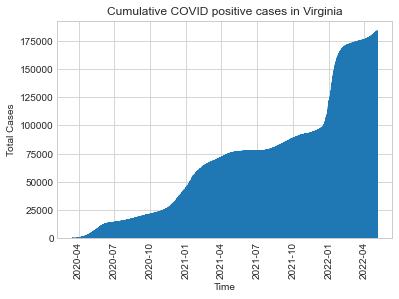

In [386]:
makePlot(covid_data, "Time", "Total Cases", "Cumulative COVID positive cases in Virginia")

As expected, the total number COVID cases in Virginia goes up over time. This is pretty intuitive as there is no way for the total cases to go down because it is a **cumulative measure**. From this chart, we can start gathering some information about COVID transmission rates. We see two sections with steep slopes - January 2020 and January 2021 which show massive relative spikes in total cases state-wide. This comes with little surprise, as the winter months involve the cold/flu season as well as lots of family gatherings which impact the rate of virus transmission.

In my opinion, plotting cases in this manner can be rather misleading. To me, this chart make it look like COVID is getting consistently worse over time. From a glance, it could be misinterpreted to think that today there are way more people getting sick from COVID today than there were last January simply because the rightmost point on the graph will always be the highest point. To get an idea of how COVID is spreading at any point in time on the above chart, you must look at the slope at that point and not the height of the point.  

I think that it will be a lot more representative to see what the cases **per day** look like if we want a better understanding of when COVID is at its worst in Virginia. Let's now plot the the `Total Cases Per Day` column as we computed previously across all counties to get a better view of the impact COVID has on Virginia residents. 

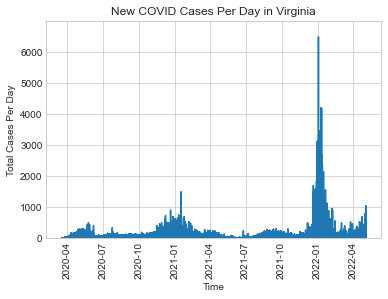

In [387]:
# Concatenate our county frames into one big frame
covid_data_enhanced = pd.concat(county_frames)

# Sort our times back to the way they were in our covid_data frame
covid_data_enhanced = covid_data_enhanced.sort_values('Time', ascending=True)

makePlot(covid_data_enhanced, "Time", "Total Cases Per Day", "New COVID Cases Per Day in Virginia")

Now we have a much better picture of what COVID looks like in Virginia across time. From this chart, we can see the same peaks in new cases that we saw in the previous chart; the peaks are much more noticeable from a glance. These spikes are pretty significant. Between December 2020 and January 2021, Virginia counties reported between 200-1000 new cases a day, with one day having 1500 new cases. As we move into April 2021, new cases significantly diminish and we see around July 2021 the number of new cases being reported in Virginia is very minimal. 

As we move into the end of 2021 and the beginning of 2022, we see a massive spike in new cases. During that period, we have a daily average of around 1500 cases with and two days with over 4000 new reported cases. As compared to the spike in 2020/2021, this new spike is visibly way worse. From a glance, the second spike in cases per day looks like it may be about three times as significant as the first.

We should take a moment to address the fact that an increase in cases **reported** does not neccesarily imply a **proportional** increase in people **contracting** the virus. There are many factors outside of actual virus contraction rates that could influence these numbers such as: availability of testing, accuracy of testing, travel restrictions/precautions during the holiday season, testing requirements of workplaces or institutions, different virus variants, and many others. As we continue our analysis, we should be aware these factors that likely influence the number of positive COVID cases being reported in each county.

Aside from these two spikes though, new cases remain relatively low in Virginia, rarely passing above 100-200 a day. In a state with over 8.5 million residents, these numbers are very low. We can also see now a bit of a rise towards the end of the graph, implying that we might be looking at the beginning of a new spike in cases right now. 

Not only does visualizing the data in this manner give us an insight on when COVID is spiking and when it isn't, it gives us a better visual representation that shows us exactly how much larger the holiday surge was last winter than compared to the surge around the same time a year prior. 

Next, let's take a look at hospitalization rates across all of Virginia.

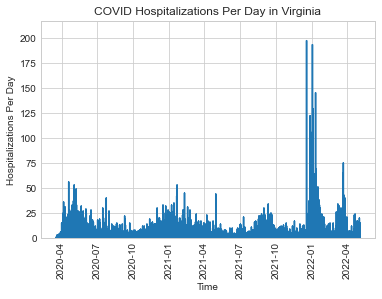

In [388]:
makePlot(covid_data_enhanced, "Time", "Hospitalizations Per Day", "COVID Hospitalizations Per Day in Virginia")

The hospitalizations per day over time match up similarly to the new cases per day. The values are significantly lower, but we can see very similar peaks around the winter months of the past two years as in the above visualization of daily cases. This comes with little surprise as if there are more people sick at a given time, we would expect to see more people hospitalized. We do notice, however, one discrepancy towards the beginning of our data collection around April 2020 which shows a relatively large spike in hospitalizations. If we compare this section in the hospitalization chart with its corresponding section in the cases per day chart, it appears that the ratio of hospitalizations per cases towards the beginning of reporting was a bit higher than it is now. This is likely due to a lack in understanding of the severity of COVID. When there was little information known about the pandemic, there was likely a lower symptom threshold for hospitalizing a patient, as doctors simply didn't know how well the average person could fight off the virus. 

The last thing we should assess when looking at the entirety of Virginia cases is the daily deaths. Let's plot that now.

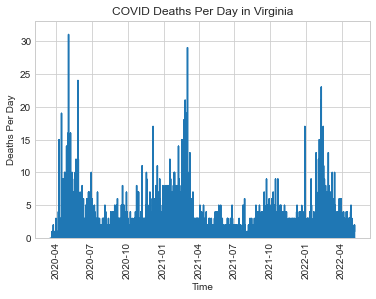

In [389]:
makePlot(covid_data_enhanced, "Time", "Deaths Per Day", "COVID Deaths Per Day in Virginia")

The deaths per day chart takes a bit of a departure from the above two plots. We see somewhat of a downward trend in daily deaths, especially when we consider the upward trend in new cases when looking at the peaks. Despite the massive increase in cases and hospitalizations in the second winter peak as compared to the first, the number of deaths per day during the second peak is not consistent with this increase. From a glance we can see that the second peak appears to have roughly the same, if not slightly less deaths per day than the first peak.

This observation could be influenced by a number of factors. The first to consider would be what we stated above which was the fact that an increase in new cases reported does not neccesarily imply a **proportional** increase in people getting sick. Another factor would be medical research's ability to treat critical patients for the virus - as we understand more about how COVID impacts the body; medicine is bound to get more effective at treating sick patients which would likely increase survival rates. A third consideration would be the differences between virus variants. During January 2022 there was a belief that the Omicron variant was spreading rapidly and there was word that this variant was more contagious but had less of a physical impact on people. This claim would be supported by these charts showing that while many more people were getting sick during the second surge, not a lot of people were dying. 

Virginia also saw a peak in reported deaths at the beginning of our dataset that was very similar to the peak seen during the first winter spike. While the cases were lower during this early reporting period, the deaths per day is fairly similar. This could be due to either underreporting of cases during this time, or a lower ability for doctors to treat high-risk patients with severe cases of the virus. Either way, when looking solely at the peak moments on this deaths per day chart while factoring in reported cases, over time the deadliness of COVID appears to be going down. 

To get a better idea of how the deadliness of COVID has changed over time, let's do a little more data manipulation to observe the rate of deaths per positive cases.

In [390]:
# Reset our indices so we can iterate through the enhanced frame
covid_data_enhanced = covid_data_enhanced.reset_index(drop=True)
deaths_per_cases = []
# For each row in the enhanced frame
for index in covid_data_enhanced.index:
    # Scrape that row's Total Cases and Deaths values 
    cases = covid_data_enhanced.at[index, 'Total Cases']
    deaths = covid_data_enhanced.at[index, 'Deaths']
    # Avoid divide by 0
    if cases == 0:
        deaths_per_cases.append(0)
    # Low sample size cases significantly throw off values, remove them
    elif cases < 50:
        deaths_per_cases.append(np.nan)
    # Else append the ratio
    else:
        deaths_per_cases.append(deaths/cases)
# Append onto our enhanced frame
covid_data_enhanced['Deaths Per Cases'] = deaths_per_cases

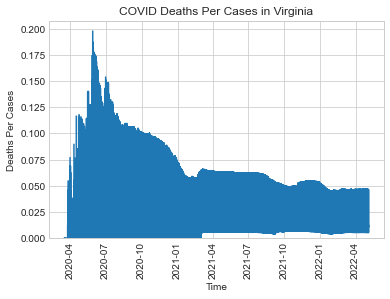

In [391]:
makePlot(covid_data_enhanced, "Time", "Deaths Per Cases", "COVID Deaths Per Cases in Virginia")

This final chart in this section supports what we theorized in the previous charts which is that the deadliness of COVID in Virginia has seemingly gone down over time. From April-June 2020 the death rate was the highest but has steadily followed a moderate negative slope since then. This is good news for the future of COVID in Virginia, because it suggests COVID will continue to become less deadly in the future. This chart also shows that the peaks in COVID cases have little to no effect on the actual death rate regardless of how rapidly COVID is spreading at any given time the chance of death remains fairly constant. 

From the visualizations of data in this section, we have been able to make the following observations about how COVID has impacted Virginia:
* There have been two major spikes in cases and hospitalizations since reporting began - one was during the winter of 2020/2021 and the second was during the winter of 2021/2022.
* While the second spike saw a massive increase in new cases reported as compared to the first, the second spike in cases saw an equal if not slightly lower death rate than the spike the year prior. 
* During the beginning of our reported data in April 2020, we saw low reported cases with high hospitalizations and a relatively high death rate. 
* The deadliness of the virus has decreased over time, with the highest rate of deaths per cases being towards the beginning of the pandemic, and death rate gradually decreasing over time. 

This concludes our **Explatory Data Analysis** section. During this section we have gathered a lot of insight onto COVID's effect on the state of Virginia. We will now move onto our next section which is hypothesis testing.

---
## Hypothesis Testing

In this section, we will attempt to answer the question: Does the population of a county have an effect on COVID case and death rates? In other words, are you more at risk of contracting and dying of COVID if you live in a heavily populated county like Fairfax or Prince William than you would be if you lived in a remote county like Highland or Norton?
To test this hypothesis, we will collect data on the most and least populated counties in Virginia. From this data, we will do some visual plotting and perform some regression tests to check to see if there are noticeable differences in regression slope.

We can start by grouping our `county_frames` data into lists based on population size. Let's define some functions to make this easy to do.

We also need to add a `date_ordinal` value based on `Time` to our DataFrames as most regression modeling libraries in Python don't handle `DateTimes` as an axis very well. A detailed explanation of the problem and workaround can be found [here](https://stackoverflow.com/questions/29308729/how-to-plot-a-linear-regression-with-datetimes-on-the-x-axis).

In [392]:
# Returns a specific county's DataFrame
def getFrame(county: str):
    for frame in county_frames:
        if frame.iloc[0,1] == county:
            return frame 

# Returns a list of the n largest populated counties
def getNLargest(n):
    # Call the nlargest function
    n_largest = populations.nlargest(n, ['Population'])['County'].to_list()  
    most_populous_frames = []
    # Append the frame of every county to most_populous_frames
    for cty in n_largest:
        most_populous_frames.append(getFrame(cty))
    # Add the date_ordinal value for regression modeling
    for df in most_populous_frames:
        df['date_ordinal'] = pd.to_datetime(df['Time']).apply(lambda date: date.toordinal())
    return most_populous_frames
     
# Returns a list of the n smallest populated counties   
def getNSmallest(n):
    # Call the nsmallest function
    n_smallest = populations.nsmallest(n, ['Population'])['County'].to_list()  
    least_populous_frames = []
    # Append the frame of every county to most_populous_frames
    for cty in n_smallest:
        least_populous_frames.append(getFrame(cty))
    # Add the date_ordinal value for regression modeling
    for df in least_populous_frames:
        df['date_ordinal'] = pd.to_datetime(df['Time']).apply(lambda date: date.toordinal())
    return least_populous_frames

With that done, let's add some code to do our regression modeling, construct our plots, and plot our regression lines. For our regression testing, we are going to be using the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) module from [sklearn](https://scikit-learn.org/stable/).

In [393]:
# Constructs line plots of a list of DataFrames and adds a regression line that represents all of the lines
def doRegPlot(dfs, yCol, title):
    # Plot the first frame on the axis
    ax = dfs[0].plot(x='date_ordinal', y=yCol, label=getName(dfs[0]))
    # Plot the remaining frames onto the same axis
    for i in range (1, len(dfs)):
        dfs[i].plot(ax=ax, x='date_ordinal', y=yCol, label=getName(dfs[i]))

    # Concatenate the frames for our regression modeling
    df = pd.concat(dfs)
    
    # Pick the axis values: x will always be date, y can be variable
    x = df['date_ordinal']
    y = df[yCol]
    X = np.array(x)
    
    # Fit the regression model
    model = LinearRegression().fit(X.reshape(-1,1),y)
    
    # Do some visual formatting and titling
    ax.set_xlabel("Date")
    # New label names because the date ordinals are just integer values which are unreadable
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)
    plt.xticks(rotation=90) 
    plt.ylim(0)
    plt.ylabel(yCol)
    plt.title(title)
    # Remove the legend if we are using a lot of frames
    if (len(dfs) > 10):
        legend = ax.legend()
        legend.remove()
    
    # Create a linspace to model our regression line onto
    x = np.linspace(x.min(),x.max(),100)
    y = model.coef_[0]*x+model.intercept_
    
    # Plot the regression line
    plt.plot(x,y, 'k--')
    
# Returns the x and y axis values for a regression line given a list of DataFrames  
def getRegLine(dfs, yCol):
    # Concatenate the frames
    df = pd.concat(dfs)
    
    # Pick the axis values: x will always be date, y can be variable
    x = df['date_ordinal']
    y = df[yCol]
    X = np.array(x)
    
    # Fit the regression model
    model = LinearRegression().fit(X.reshape(-1,1),y)
    
    # Create a linspace to model our regression line onto and return axis
    x = np.linspace(x.min(),x.max(),100)
    y = model.coef_[0]*x+model.intercept_    
    return(x,y)

# Plots the regression lines of two lists of DataFrames on top of each other 
def plotRegression(most_populous_frames, least_populous_frames, yCol, title):
    # Define axis
    ax = plt.subplot()
    
    # Get the regression line values of both lists of frames
    (x_most, y_most) = getRegLine(most_populous_frames, yCol)
    (x_least, y_least) = getRegLine(least_populous_frames, yCol)
    
    # Plot the lines and give them their labels
    plt.plot(x_most, y_most, label='Most Populated')
    plt.plot(x_least, y_least, label='Least Populated')
    
    # New label names because the date ordinals are just integer values which are unreadable
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)
    
    # Visual formatting and titling
    plt.xticks(rotation=90) 
    plt.ylabel(yCol)
    plt.xlabel('Date')
    plt.title(title)
    plt.legend()

We should be good to go! Let's pick out ten of the largest and ten of the smallest counties by population and plot their regression lines based on their `Total Cases Per Capita` value that we computed earlier. Note that the only way for us to get a good representation of chance of illness is to use these per-capita values as we want to look at the percentage chance of contracting the virus based on population size and not how many people got sick in each county. For example, 1,000 new cases in a county of 5,000 residents means a lot more than it does in a county of over 1 million residents!

In [394]:
most_populous_frames = getNLargest(10)
least_populous_frames = getNSmallest(10)

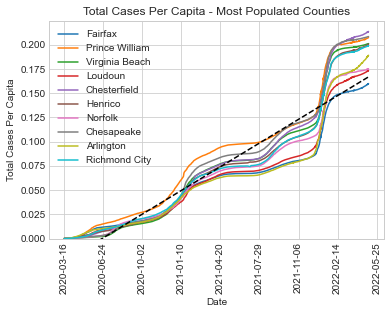

In [395]:
doRegPlot(most_populous_frames, 'Total Cases Per Capita', 'Total Cases Per Capita - Most Populated Counties');

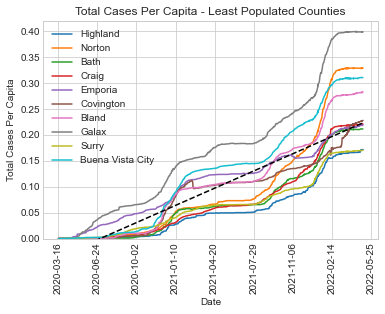

In [396]:
doRegPlot(least_populous_frames, 'Total Cases Per Capita', 'Total Cases Per Capita - Least Populated Counties');

Our two groupings of counties follow similar trends. Some things to notice, however, the more populated counties appear to have a tighter distribution of cases per capita as compared to the less populated counties. This makes intuitive sense as the less populated counties have a smaller sampling size of people which will attribute to higher variance in that data. In other words, an outlier increase (or reduction) of 200 cases in a single day will have a much more significant impact on a county with a couple thousand residents than it would in a county with hundreds of thousands or a million residents. 

Let's plot these two regression lines on top of each other to see if we can make a comparison between them.

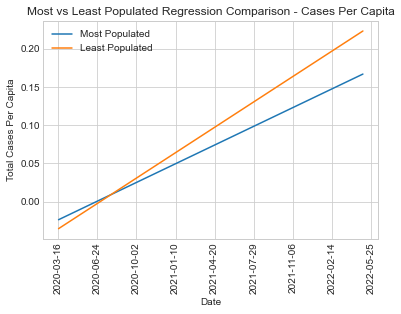

In [397]:
plotRegression(most_populous_frames,least_populous_frames,'Total Cases Per Capita','Most vs Least Populated Regression Comparison - Cases Per Capita')

Overlapping these regression lines shows us that our ten smallest and largest counties by population have very similar trends in new cases reported. There is a slight divergence in slope that acutally counters what I would have intuitively expected which would be the more populated areas having faster rates of spread, however it is extremely slight. From this modeling, there is inconclusive evidence to suggest that county population has a significant impact on COVID transmission rates.

Before we finish looking at cases per capita, let's increase our sample sizes and run the same plots we performed earlier. We can split our entire dataset in half and take the largest and smallest counties in all of Virginia to run our analysis. By doing so, we greatly increase our sampling size to reduce our variance. Thus, we should get better represenation of any significant relationship between population density and COVID transmission rates.

In [398]:
most_populous_frames = getNLargest(66)
least_populous_frames = getNSmallest(66)

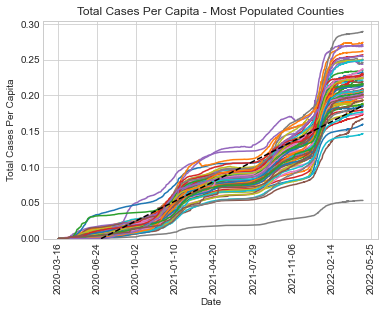

In [399]:
doRegPlot(most_populous_frames, 'Total Cases Per Capita', 'Total Cases Per Capita - Most Populated Counties')

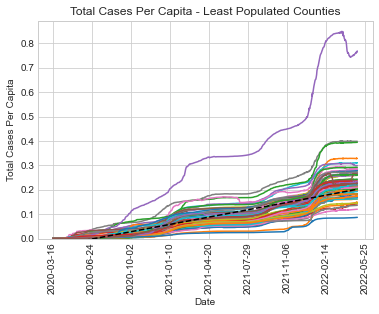

In [400]:
doRegPlot(least_populous_frames, 'Total Cases Per Capita', 'Total Cases Per Capita - Least Populated Counties')

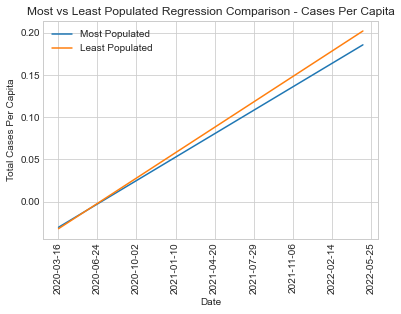

In [401]:
plotRegression(most_populous_frames,least_populous_frames,'Total Cases Per Capita','Most vs Least Populated Regression Comparison - Cases Per Capita')

Once again, we see two nearly identical regression lines with very similar slopes. From this analysis, it is safe to conclude that no relationship exists between population density and COVID transmission rate. 

Finally, let's look at `Deaths Per Capita` amongst the most and least populous counties in Virginia.

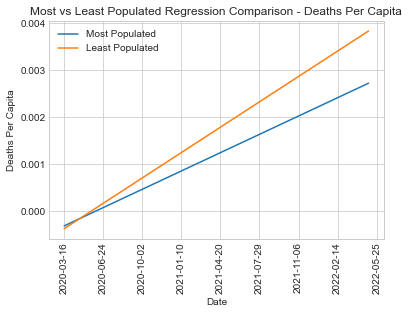

In [402]:
plotRegression(most_populous_frames,least_populous_frames,'Deaths Per Capita','Most vs Least Populated Regression Comparison - Deaths Per Capita')

Here we see a very mild divergence in slope when looking at death rates. The least populated counties have up to a 0.1% increase in death rate over the more populated counties. Based on this data, it is safe to conclude that a mild negative correlation between population size and death rate exists, meaning that residents of less populated counties have a slightly higher chance of dying from COVID.

We should be very careful in how we interpret this information. Our prior analysis shows little to no correlation between population density and COVID contraction/case rate exists. This doesn't mean that there are more people getting sick in these less populated areas of Virginia. This means that this slight increase in death rate is likely caused by other factors that exist in these lesser populated counties such as health standards or healthcare accessability.

This concludes the **Hypothesis Testing** section of our tutorial. We will summarize our findings in the final section.

---
## Insights Attained

Before summarizing our findings, I want to quickly touch on the accuracy of the data we have been analyzing. There is no reasonable way to obtain 100% accurate data on a global pandemic with so many factors that can impact reporting accuracy. Reporting consistency across different hospitals and counties, availability/accuracy of testing equipment, and factors that push more/less people to get tested (such as government/workplace regulations and media influence) are to name just a few of such factors. 

With that being said, this is the data we have available, so this is what we must go off of to draw our conclusions. Thus, we will have to take our findings here with a grain of salt. I **highly** encourage all readers to do their **own** research and draw their **own** conclusions through the most reliable evidence and data they have available - not just for COVID, but for everything you wish to have a public opinion on. Especially if you feel compelled to tweet about it! With that out of the way, let's overview what we have found in this analysis.

#### Findings
1. Virginia saw two major spikes in COVID **cases** - spike 1 occurred during the winter of 2020/2021 and spike 2 occurred during the winter of 2021/2022.
2. Spike 2's **cases per day** increase was significantly **larger** than Spike 1's. This could be influenced by the following factors (and/or others):
    * Increased testing by the general population, perhaps in preparation for holiday travel.
    * People getting together for the holidays resulting in a lapse of social distancing at gatherings.
    * Transmission of the Omicron variant which was allegedly much more contagious.
    * Increased awareness/fear of the virus as influenced by the media leading to more people getting tested.
3. Spike 2 saw **fewer** **deaths per day** than both spike 1 and the first few reporting days despite a **massive increase** in **cases per day**.
4. In the earliest days of COVID reporting during April 2020, Virginia had **high deaths and hospitalizations per day** and its **highest** rate of **deaths per cases**.
5. The **deadliness** of COVID has **decreased** over time. This could be due to the following factors (and/or others):
    * Increased efficacy of healthcare.
    * Increased accessability to healthcare.
    * The virus getting weaker over time.
6. There is **insufficient evidence** to conclude that there exists a relationship between **population density** and **transmission rate**. The proportion of  **cases** in counties of varying populations is **consistent**. 
7. There is **sufficient evidence** to conclude that a **mild** relationship exists between **population density** and **death rate**. Counties with low populations saw at most a **0.1% higher death rate** than counties with high populations. Note that as per point 5, this is **not** due to an increase in **transmission rate** in these counties. Possible reasons for this increase in death rate could include the following (and/or others):
    * Lower accessibility to adequate healthcare.
    * A lower average level of physical health.

This concludes our findings and our tutorial. Thanks for reading!